In [40]:
'''
Module to create and manipulate the graph
'''
import json
import pickle
import heapq as hp
import networkx as nx
from conf import *
import tqdm

class Graph():
    
    '''
    Class to create and manipulate a graph using the NetworkX package
    '''

    def __init__(self, reduced = False, full = True):
        if reduced:
            try:
                self._load_graph(reduced)
            except:
                self._create_graph(RED_DATA, True)
        if full:
            try:
                self._load_graph(False)
            except:
                self._create_graph(FULL_DATA, False)

        
    def _create_graph(self, data_path, reduced = False):
        
        with open(data_path) as data_file:
            data = json.load(data_file)
            
        graph = nx.Graph()
        
        for entry in tqdm.tqdm(data, desc="Creating graph..."):
            
            conference = {
                    "id_str":entry["id_conference"],
                    "id_int":entry["id_conference_int"]
            }
            publication = {
                    "id_str": entry["id_publication"],
                    "id_int": entry["id_publication_int"],
                    "title": entry["title"]
            }
            nodes_id = []
            
            for author in entry["authors"]:
                try:
                    node = graph.node[author["author_id"]]["data"]
                except:
                    new_author = {
                            "name": author["author"],
                            "id": author["author_id"]
                    }
                    node = {
                            "author": new_author,
                            "publications": {},
                            "conferences": {}
                    }

                    graph.add_node(new_author['id'], data = node)
                    
                node['publications'][publication['id_int']] = publication
                node['conferences'][conference['id_int']] = conference
                
                if nodes_id:
                    for node_id in nodes_id:
                        graph.add_edge(node_id, author["author_id"], weight = None)
                nodes_id.append(author["author_id"])
        
        if reduced:
            self.red_graph = graph
        else:
            self.graph = graph

        self._add_weights(reduced)
        self._save_graph(reduced)
        

    def _add_weights(self, reduced = False):
        if reduced:
            _graph = self.red_graph
        else:
            _graph = self.graph
        edges_ids = _graph.edges()
        for node_id1, node_id2 in tqdm.tqdm(edges_ids, desc = "Adding weights..."):
            node1 = _graph.node[node_id1]["data"]
            node2 = _graph.node[node_id2]["data"]
            jaccard = self._jaccard_sim(node1, node2)
            _graph[node_id1][node_id2]["weight"] = jaccard

    def _jaccard_sim(self, node1, node2):
        pubs1 = set(node1['publications'].keys())
        pubs2 = set(node2['publications'].keys())
        jaccard = 1 - (len(pubs1.intersection(pubs2))/len(pubs1.union(pubs2)))
        return jaccard
    
    def get_subgraph_conf(self, conference_id: int, reduced=False):
        _graph = self.red_graph if reduced else self.graph
        subgraph_ids = []
        for node in _graph.nodes(data=True):
            data = node[1]['data']
            conferences = data['conferences']
            try:
                _ = conferences[conference_id]
                subgraph_ids.append(node[0])
            except KeyError:
                pass
        subgraph = _graph.subgraph(subgraph_ids)
        return subgraph

    def get_subgraph_author(self, author_id: int, d: int,reduced=False):
        _graph = self.red_graph if reduced else self.graph
        author_ids = [author_id]
        subgraph_ids = []
        node_list = [[author_id]]
        set_author_id = set(node_list[0])
        for i in range(d):
            edges = []
            for aut_id in author_ids:
                edges.extend(list(_graph[aut_id].keys()))
            author_ids = list(set(edges))
            node_list.append(list(set(author_ids).difference(set_author_id)))
            subgraph_ids.extend(author_ids)
            set_author_id = set_author_id.union(set(author_ids))
        subgraph = _graph.subgraph(subgraph_ids)
        return subgraph, node_list


    def _get_edges(self, author_id: int, d: int, reduced=False):
        _graph = self.red_graph if reduced else self.graph
        subgraph = []
        edges = list(_graph.graph[author_id].keys())
        if d == 0:
            return edges
        else:
            for edge in edges:
                subgraph.append(self._get_edges(edge, d-1, reduced))
        return subgraph

    def _save_graph(self, reduced = False):
        filename = RED_GRAPH if reduced else GRAPH
        _graph = self.red_graph if reduced else self.graph
        with open(filename, 'wb') as output:
            pickle.dump(_graph, output, pickle.HIGHEST_PROTOCOL)
    
    def _load_graph(self, reduced = False):
        filename = RED_GRAPH if reduced else GRAPH
        with open(filename, 'rb') as input_graph:
            _graph = pickle.load(input_graph)
            if reduced:
                self.red_graph = _graph
            else:
                self.graph = _graph

    def aris_distance(self, reduced = False, author_id = -1):
        _graph = self.graph if not reduced else self.red_graph
        aris = None
        # Find Aris
        for node in _graph.nodes():
            author_name = _graph.node[node]['data']['author']['name']
            if 'aris anagnostopoulos' == author_name.lower():
                aris = node
                break
        if aris is None:
            print('Aris not found')
            return None
        dist = self._shortest_path(start=author_id, finish = aris, graph=_graph)
        return dist
                
    def _shortest_path(self, start = None, finish = None, graph = None):
        '''
        Dijkstra's algorithm implementation using a priority queue (heapq)
        '''
        distances = {}
        for node in graph.nodes():
            if node == start:
                distances[node] = 0
            else:
                distances[node] = float('inf')
        p_queue = []
        hp.heappush(p_queue, (0, start))
        visited = set()
        while p_queue:
            dist, node = hp.heappop(p_queue)
            if finish is not None:
                if node == finish:
                    return dist
            if node not in visited:
                visited.add(node)
                for edge in graph.edges(node, data=True):
                    neighbour = edge[1]  
                    weigth = edge[2]['weight']
                    _dist = dist + weigth
                    if _dist < distances[neighbour]:
                        distances[neighbour] = _dist
                    if neighbour not in visited:
                        hp.heappush(p_queue, (_dist, neighbour))
        return distances

    def set_group_number(self, nodes_list = None, reduced = False):
            _graph = self.graph if not reduced else self.red_graph
            nodes = _graph.nodes()
            self.group_numbers_red = {}
            self.group_numbers = {}
            _group_numbers = self.group_numbers if not reduced else self.group_numbers_red
            dists = []
            for sub_node in tqdm.tqdm(nodes_list):
                distances = self._shortest_path(start=sub_node, graph=_graph)
                dists.append(distances)
            for node in nodes:
                _group_numbers[node] = min([dist[node] for dist in dists])

In [39]:
g = Graph(reduced=True, full=True)
nodes_list = [15905, 113665, 58666, 62227]

In [41]:
aris = g.aris_distance(reduced=False, author_id=1)

In [42]:
print(aris)

5.361455205205205


In [45]:
for node in g.graph.nodes():
    author_name = g.graph.node[node]['data']['author']['name']
    if 'aris anagnostopoulos' == author_name.lower():
        aris = node
        print(node)

256176


In [44]:
nx.shortest_path_length(g.graph, source=1, target=256176, weight='weight')

5.361455205205205

In [13]:
g.set_group_number(nodes_list, reduced = False)

100%|██████████| 4/4 [01:46<00:00, 26.26s/it]


In [19]:
g.group_numbers[1]

4.681999986067688

In [20]:
for i in nodes_list:
    print(nx.shortest_path_length(g.graph,source=i, target=1, weight='weight'))

5.398236078529685
5.493434060475912
5.350490836271821
4.681999986067688


In [25]:
g.graph.node[1]['data']['author']['name'].lower()

'pierre seimandi'

In [26]:
'aris' in 'aris agnosoosts'

True

In [75]:
def get_centralities(self, graph):
    _graph = graph
    degree = nx.degree(_graph) 
    closeness = nx.closeness_centrality(_graph)
    betweenness = nx.betweenness_centrality(_graph)
    return degree, closeness, betweenness

In [83]:
sub = g.get_subgraph_conf(reduced=True, conference_id=11196)

In [84]:
d, c, b = get_centralities(None, sub)

In [127]:
pos = nx.spring_layout(sub,k=.12)

nodeID = list(sub.node.keys())

nodeID.sort()

def scatter_nodes(pos, labels=None, color='rgb(152, 0, 0)', size=8, opacity=1):
    # pos is thedict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between [0,1] defining the node color opacity

    trace = Scatter(x=[], 
                    y=[],  
                    mode='markers', 
                    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='Greens',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Betweeenness Centrality',
            xanchor='left',
            titleside='right'
        ),
    line=dict(width=2)))
    for nd in nodeID:
        trace['x'].append(pos[nd][0])
        trace['y'].append(pos[nd][1])
        trace['marker']['color'].append(d[nd])
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size

    return trace

def scatter_edges(G, pos, line_color='#a3a3c2', line_width=1, opacity=.2):
    trace = Scatter(x=[], 
                    y=[], 
                    mode='lines',
                   )
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace
labels = []
for node in sub.nodes():
    author_name = sub.node[node]['data']['author']['name']
    labels.append(author_name)

trace1=scatter_edges(sub, pos)
trace2=scatter_nodes(pos, labels=labels)

In [128]:

width=600
height=600
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= '#EdTechChat Community on Twitter',
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=dict(
        title='Dec 14, 2015 9-10 p.m. EST, #EdTechChat #NETP16   www.techpoweredmath.com',
        titlefont=dict(
        size=14,
        color='#7f7f7f'),
        showline=False,
        showticklabels=False,
        zeroline=False
    ),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])

fig = Figure(data=data, layout=layout)

In [129]:
py.sign_in('pedromb', 'TlIljucKaOICBzGtZ6QO')
py.iplot(fig, filename='EdTechChat')

{10: array([ 0.41562906,  0.70793122], dtype=float32), 257: array([ 0.57285535,  0.60315263], dtype=float32), 322: array([ 0.34722552,  0.46075505], dtype=float32), 979: array([ 0.78854799,  0.35189849], dtype=float32), 1011: array([ 0.4689635 ,  0.47535536], dtype=float32), 1170: array([ 0.55318505,  0.03965723], dtype=float32), 1829: array([ 0.73231387,  0.46073857], dtype=float32), 2095: array([ 0.38622072,  0.56454134], dtype=float32), 2457: array([ 0.43080717,  0.59913582], dtype=float32), 2574: array([ 0.79873091,  0.4083415 ], dtype=float32), 3199: array([ 0.4483383 ,  0.43218622], dtype=float32), 3962: array([ 0.73612195,  0.47108859], dtype=float32), 6126: array([ 0.33712962,  0.33057979], dtype=float32), 8312: array([ 0.40912104,  0.55809176], dtype=float32), 8338: array([ 0.54170769,  0.49401295], dtype=float32), 8358: array([ 0.39474338,  0.16876937], dtype=float32), 8393: array([ 0.44629979,  0.59434545], dtype=float32), 8410: array([ 0.23885605,  0.25916618], dtype=float3

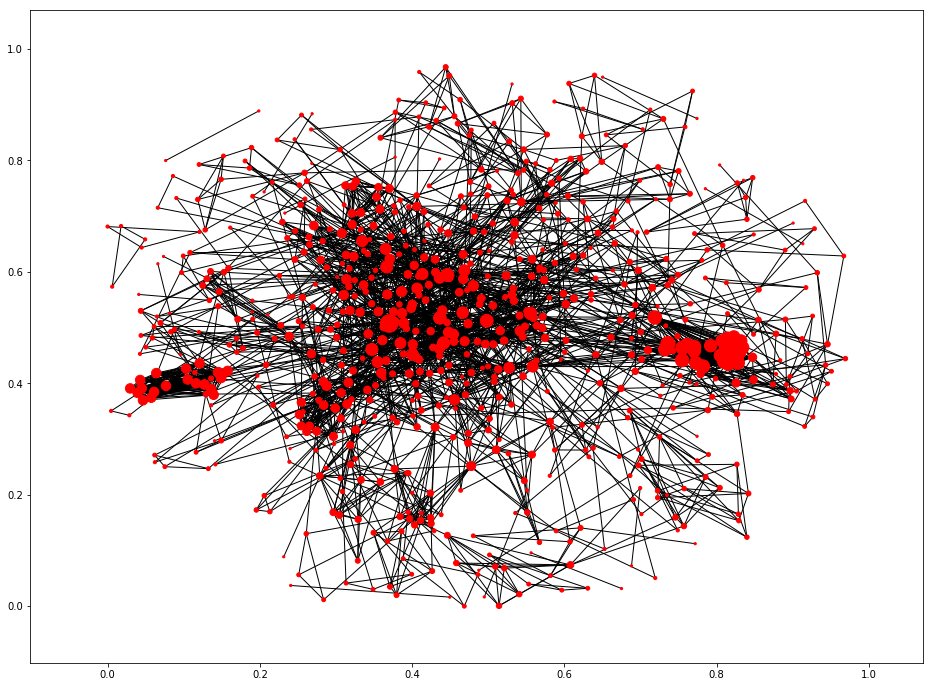

In [114]:

import matplotlib.pyplot as plt
pos = nx.spring_layout(sub,k=0.2,iterations=50)
print(pos)
plt.figure(figsize=(16,12))
nx.draw_networkx(sub, pos = pos, with_labels=False, node_list=list(d.keys()), 
                 node_size=list(map(lambda x: x*5, d.values())))
plt.show()

In [52]:
d, c, b = get_centralities(None, sub)

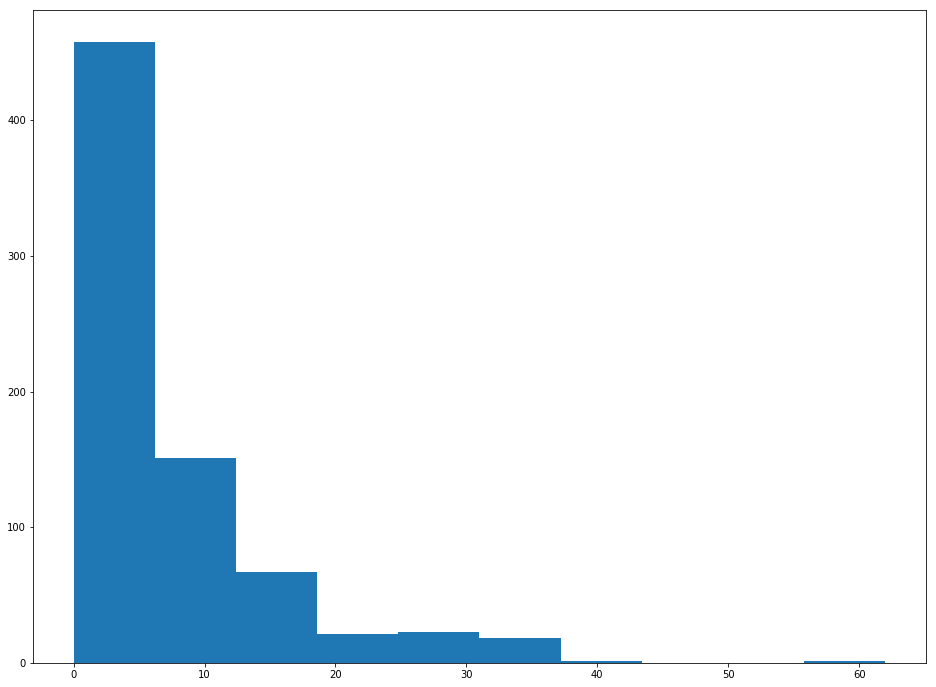

In [130]:
plt.figure(figsize=(16,12))
plt.hist(list(d.values()))
plt.show()